# Forecasting - Facebook Prophet

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt





%matplotlib inline
mpl.rcParams['figure.figsize'] = (16, 10)
pd.set_option('display.max_rows', 500)

import plotly.graph_objects as go

In [2]:

#!pip install prophet

In [3]:
#attention might have problems with holiday package, 
#downgrate holidays via: pip install 'holidays==0.9.12'
from prophet import Prophet 

In [4]:
%matplotlib inline
plt.style.use('fivethirtyeight')

In [5]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Trivial Forecast (rolling mean)


In [6]:
# the final trivial model is at the end of this file

df = pd.DataFrame({'X': np.arange(0,10)}) # generate an input df
df['y']=df.rolling(3).mean() # take the window and write the average as the result

In [7]:
df

,X,y
0,0,NaN
1,1,NaN
2,2,1.0
3,3,2.0
4,4,3.0
5,5,4.0
6,6,5.0
7,7,6.0
8,8,7.0
9,9,8.0


In [8]:
df_all = pd.read_csv('../data/processed/new_COVID_small_flat_table.csv',sep=';')
df=df_all[['date','Germany']]
df=df.rename(columns={'date': 'ds',
                        'Germany': 'y'})

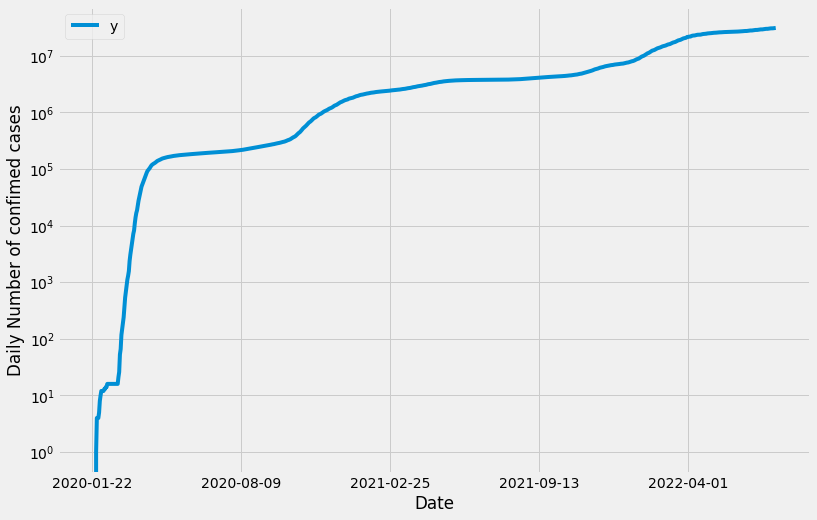

In [9]:
ax = df.set_index('ds').plot(figsize=(12, 8),
                             logy=True)
ax.set_ylabel('Daily Number of confimed cases')
ax.set_xlabel('Date')

plt.show()

In [10]:
# set the uncertainty interval to 95% (the Prophet default is 80%)

#my_model = Prophet(interval_width=0.95) # piecwise linear model
my_model = Prophet(growth='logistic')   # logistic model

In [11]:
# the column 'cap' is only mandatory for the logistic model
df['cap']=1000000.
my_model.fit(df)

00:32:19 - cmdstanpy - INFO - Chain [1] start processing
00:32:19 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
# define the periods and the frequency 'D'== days

future_dates = my_model.make_future_dataframe(periods=7, freq='D')
future_dates['cap']=1000000. # only mandatory for the logistic model
future_dates.tail()

,ds,cap
921,2022-07-31,1000000.0
922,2022-08-01,1000000.0
923,2022-08-02,1000000.0
924,2022-08-03,1000000.0
925,2022-08-04,1000000.0


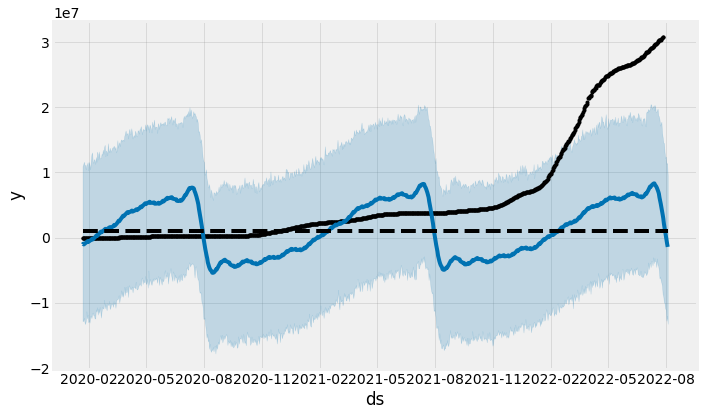

In [13]:
# predict according to the scikit-learn standard

forecast = my_model.predict(future_dates)
my_model.plot(forecast,
              uncertainty=True ); # since fbprohet is rendering the output

In [14]:
import plotly.offline as py
from prophet.plot import plot_plotly

fig = plot_plotly(my_model, forecast)  # This returns a plotly Figure

fig.update_layout(
    width=1024,
    height=900,
    xaxis_title="Time",
    yaxis_title="Confirmed infected people (source johns hopkins csse, log-scale)",
)
fig.update_yaxes(type="log",range=[1.1,5.5])
py.iplot(fig)

In [15]:
forecast.sort_values(by='ds').head()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,127721.181737,1000000.0,-1.279889e+07,1.097239e+07,127721.181737,127721.181737,-1.182749e+06,-1.182749e+06,-1.182749e+06,62545.441522,62545.441522,62545.441522,-1.245294e+06,-1.245294e+06,-1.245294e+06,0.0,0.0,0.0,-1.055028e+06
1,2020-01-23,128840.776130,1000000.0,-1.278785e+07,1.121236e+07,128840.776130,128840.776130,-1.067862e+06,-1.067862e+06,-1.067862e+06,105730.330739,105730.330739,105730.330739,-1.173592e+06,-1.173592e+06,-1.173592e+06,0.0,0.0,0.0,-9.390211e+05
2,2020-01-24,129968.722485,1000000.0,-1.231060e+07,1.163121e+07,129968.722485,129968.722485,-1.180248e+06,-1.180248e+06,-1.180248e+06,-73710.018330,-73710.018330,-73710.018330,-1.106538e+06,-1.106538e+06,-1.106538e+06,0.0,0.0,0.0,-1.050279e+06
3,2020-01-25,131105.057441,1000000.0,-1.291611e+07,1.115614e+07,131105.057441,131105.057441,-1.094958e+06,-1.094958e+06,-1.094958e+06,-50991.054542,-50991.054542,-50991.054542,-1.043967e+06,-1.043967e+06,-1.043967e+06,0.0,0.0,0.0,-9.638533e+05
4,2020-01-26,132249.817336,1000000.0,-1.325935e+07,1.114243e+07,132249.817336,132249.817336,-1.023492e+06,-1.023492e+06,-1.023492e+06,-37938.367564,-37938.367564,-37938.367564,-9.855534e+05,-9.855534e+05,-9.855534e+05,0.0,0.0,0.0,-8.912419e+05


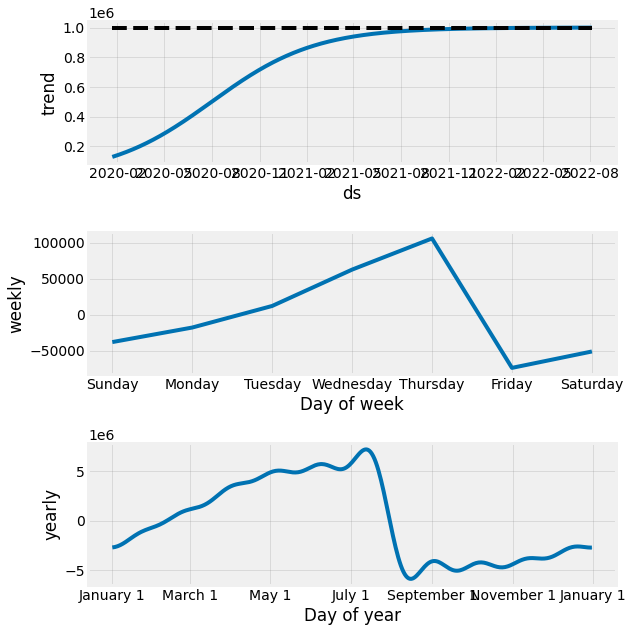

In [16]:
my_model.plot_components(forecast);

<AxesSubplot:xlabel='ds'>

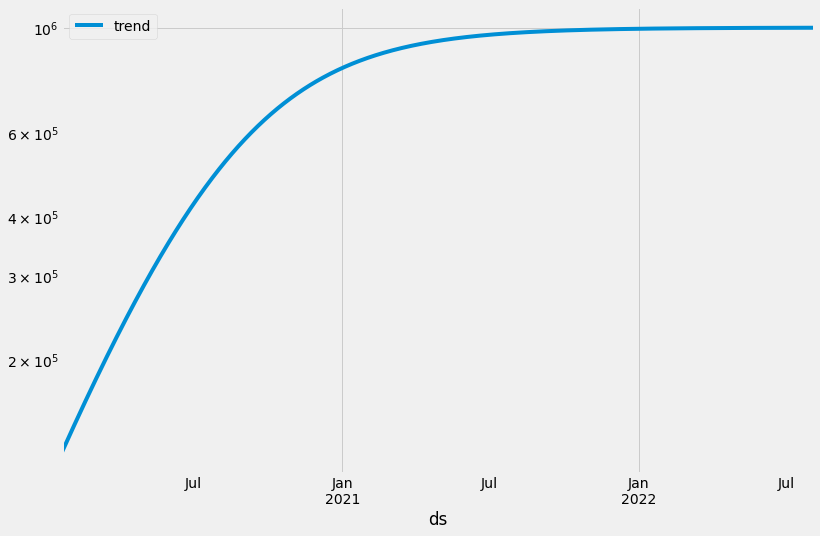

In [17]:
forecast[['ds','trend']].set_index('ds').plot(figsize=(12, 8),logy=True)

In [18]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(my_model, 
                         initial='40 days', # we take the first 30 days for training
                         period='1 days',  # every  days a new prediction run
                         horizon = '7 days') #we predict 7days into the future

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/872 [00:00<?, ?it/s]

00:32:31 - cmdstanpy - INFO - Chain [1] start processing
00:33:03 - cmdstanpy - INFO - Chain [1] done processing
00:33:07 - cmdstanpy - INFO - Chain [1] start processing
00:33:54 - cmdstanpy - INFO - Chain [1] done processing
00:33:57 - cmdstanpy - INFO - Chain [1] start processing
00:34:28 - cmdstanpy - INFO - Chain [1] done processing
00:34:31 - cmdstanpy - INFO - Chain [1] start processing
00:34:50 - cmdstanpy - INFO - Chain [1] done processing
00:34:53 - cmdstanpy - INFO - Chain [1] start processing
00:36:27 - cmdstanpy - INFO - Chain [1] done processing
00:36:31 - cmdstanpy - INFO - Chain [1] start processing
00:37:08 - cmdstanpy - INFO - Chain [1] done processing
00:37:12 - cmdstanpy - INFO - Chain [1] start processing
00:37:31 - cmdstanpy - INFO - Chain [1] done processing
00:37:35 - cmdstanpy - INFO - Chain [1] start processing
00:38:13 - cmdstanpy - INFO - Chain [1] done processing
00:38:17 - cmdstanpy - INFO - Chain [1] start processing
00:38:47 - cmdstanpy - INFO - Chain [1]

In [19]:
df_cv.sort_values(by=['cutoff','ds'])[0:12]
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-03-03,209.497127,206.834437,212.361686,188,2020-03-02
1,2020-03-04,278.613218,275.776676,281.775174,240,2020-03-02
2,2020-03-05,362.477181,358.539368,366.540085,349,2020-03-02
3,2020-03-06,465.973276,460.552210,471.423304,534,2020-03-02
4,2020-03-07,583.659417,576.223383,590.842259,684,2020-03-02


In [20]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)

In [21]:
# the performance matrix shows the result for all horizon
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,8.807330e+13,9.384737e+06,5.221837e+06,0.473918,0.580851,0.776929,0.071101
1,2 days,9.287418e+13,9.637125e+06,5.382796e+06,0.492632,0.603142,0.820672,0.036697
2,3 days,9.779181e+13,9.888974e+06,5.543866e+06,0.510931,0.625092,0.865525,0.020642
3,4 days,1.027856e+14,1.013833e+07,5.703723e+06,0.529925,0.647124,0.912200,0.016055
4,5 days,1.078000e+14,1.038268e+07,5.860902e+06,0.549416,0.671363,0.960215,0.008028
5,6 days,1.127760e+14,1.061960e+07,6.013936e+06,0.568346,0.690574,1.005738,0.008028
6,7 days,1.176554e+14,1.084691e+07,6.161506e+06,0.587544,0.712190,1.045450,0.004587


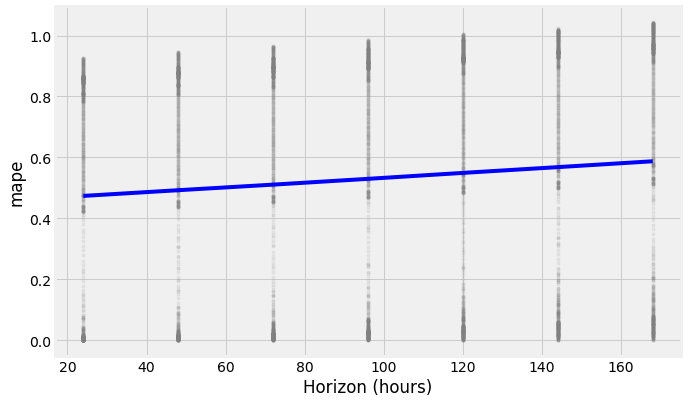

In [22]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape',)

# Diagonalplot
gives a good understanding for the under and over estimation w.r.t. magnitude

In [23]:
horizon='7 days'
df_cv['horizon']=df_cv.ds-df_cv.cutoff

date_vec=df_cv[df_cv['horizon']==horizon]['ds']
y_hat=df_cv[df_cv['horizon']==horizon]['yhat']
y=df_cv[df_cv['horizon']==horizon]['y']

In [24]:
df_cv_7=df_cv[df_cv['horizon']==horizon]
df_cv_7.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,horizon
6075,2022-07-24,-1.123004e+06,-1.184395e+07,9.831385e+06,30331133,2022-07-17,7 days
6082,2022-07-25,-1.175035e+06,-1.286506e+07,1.067589e+07,30476605,2022-07-18,7 days
6089,2022-07-26,-1.187768e+06,-1.259507e+07,1.106699e+07,30598385,2022-07-19,7 days
6096,2022-07-27,-1.196008e+06,-1.288812e+07,1.053196e+07,30702511,2022-07-20,7 days
6103,2022-07-28,-1.222772e+06,-1.270168e+07,1.008891e+07,30787309,2022-07-21,7 days


In [25]:
type(df_cv['horizon'][0])

pandas._libs.tslibs.timedeltas.Timedelta

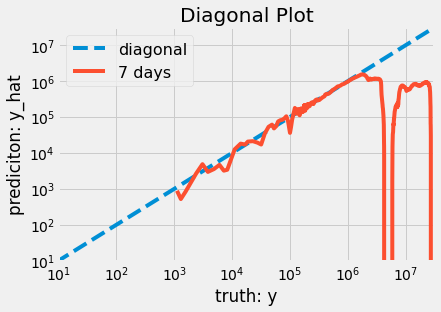

In [26]:
fig, ax = plt.subplots(1, 1)


ax.plot(np.arange(max(y)),np.arange(max(y)),'--',label='diagonal')
ax.plot(y,y_hat,'-',label=horizon)  # horizon is a np.timedelta objct

ax.set_title('Diagonal Plot')
ax.set_ylim(10, max(y))

ax.set_xlabel('truth: y')
ax.set_ylabel('prediciton: y_hat')
ax.set_yscale('log')

ax.set_xlim(10, max(y))
ax.set_xscale('log')
ax.legend(loc='best',
           prop={'size': 16});

# Trivial Forecast
Example trivial forecast, prediciton 7 days into the future

In [27]:
def mean_absolute_percentage_error(y_true, y_pred): 
    ''' MAPE calculation '''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [28]:
parse_dates=['date']
df_all = pd.read_csv('../data/processed/new_COVID_small_flat_table.csv',sep=';',parse_dates=parse_dates)
df_trivial=df_all[['date','Germany']]
df_trivial=df_trivial.rename(columns={'date': 'ds',
                        'Germany': 'y'})

# One of the standard forecast is a rolling mean
An other standard forecast is the exponentially-weighted moving average, see pandas.ewma

In [29]:
df_trivial['y_mean_r3']=df_trivial.y.rolling(3).mean() # take the average of 3 days

In [30]:
# the result has to be shifted according to the prediciton horizon (here 7 days)

df_trivial['cutoff']=df_trivial['ds'].shift(7)
df_trivial['y_hat']=df_trivial['y_mean_r3'].shift(7)
df_trivial['horizon']=df_trivial['ds']-df_trivial['cutoff']
print('MAPE: '+str(mean_absolute_percentage_error(df_trivial['y_hat'].iloc[12:,], df_trivial['y'].iloc[12:,])))
df_trivial

MAPE: 35.298691620293084


,ds,y,y_mean_r3,cutoff,y_hat,horizon
0,2020-01-22,0,NaN,NaT,NaN,NaT
1,2020-01-23,0,NaN,NaT,NaN,NaT
2,2020-01-24,0,0.000000e+00,NaT,NaN,NaT
3,2020-01-25,0,0.000000e+00,NaT,NaN,NaT
4,2020-01-26,0,0.000000e+00,NaT,NaN,NaT
...,...,...,...,...,...,...
914,2022-07-24,30331133,3.033113e+07,2022-07-17,2.969299e+07,7 days
915,2022-07-25,30476605,3.037962e+07,2022-07-18,2.974655e+07,7 days
916,2022-07-26,30598385,3.046871e+07,2022-07-19,2.984712e+07,7 days
917,2022-07-27,30702511,3.059250e+07,2022-07-20,2.999322e+07,7 days
